# Macro research topic 1
## Quantifying geopolitical uncertainty that isn’t yet reflected in the markets


### Introduction

-  The world is currently experiencing more conflicts than at any time since the post-9/11 Iraq war.
-  I believe the risk of nuclear war is at its highest level since the Cold War.
-  Despite these risks, the S&P 500 keeps reaching new highs, driven by the ChatGPT initiated tech boom.
-  Markets seem aware of war risks, as shown by Bitcoin's quick drop when Iran attacked Israel with war drones. S&P 500 did not reflect this drop as it was a Sunday.
-  This leads me to believe that that markets believe AI's economic benefits outweigh the potential negative impacts of war.
-  This study aims to:
  1. Measure the positive effects of AI and negative effects of war on the economy
  2. Analyze how these 2 factors are currently priced into markets
  3. Compare the current situations with the 2000 tech boom and Cold War era to identify possible future scenarios.

### Hypotheses

1. **AI's Economic Impact vs. War Risks**  
   Hypothesis: The S&P 500 and other global indices are more influenced by AI-driven growth trends than by geopolitical risks such as conflicts or war.

   - Test: Analyze correlations between AI-driven tech indices (e.g., NASDAQ Composite or specific AI-related ETFs) and macroeconomic indicators (e.g., GDP, unemployment). Compare these correlations during different periods of conflict.

2. **Bitcoin as a Geopolitical Risk Barometer**  
   Hypothesis: Bitcoin responds more rapidly to geopolitical tensions compared to traditional equity indices due to its decentralized nature.

   - Test: Analyze intraday price movements of Bitcoin and compare them to the S&P 500 during major geopolitical events, such as the Iran-Israel drone attack.

3. **Market Resilience During Conflict**  
   Hypothesis: The current resilience of the S&P 500 to geopolitical shocks is comparable to market behavior during the Cold War and the 2000 Tech Boom, suggesting that technological optimism outweighs geopolitical fears.

   - Test: Compare volatility indices (e.g., VIX) and treasury yields during key geopolitical tensions across the Cold War, 2000 Tech Boom, and post-2022 AI boom.

4. **Geopolitical Risk Premium in Fixed Income**  
   Hypothesis: Treasury yields reflect a greater sensitivity to geopolitical risks compared to equity indices, acting as a haven during periods of heightened tensions.

   - Test: Compare movements in 10-year and 30-year Treasury yields during major geopolitical events with equity indices' performance.

5. **Liquidity Indicators and War Risks**  
   Hypothesis: Increased liquidity injections by central banks during geopolitical crises stabilize markets, reducing immediate impacts of conflict-related news.

   - Test: Compare changes in the Federal Reserve Balance Sheet (WALCL) and Overnight Reverse Repo Agreements (RRPONTSYD) during major conflicts.

### Methodology

1. **Time Period Analysis**  
   Segment the dataset into the predefined periods:  
   - Post-2022 AI Tech Boom  
   - Cold War  
   - 2000 Tech Boom  

   Use these periods to analyze how macroeconomic indicators, equity indices, and fixed-income instruments responded to technological trends and geopolitical risks.

2. **Volatility and Sensitivity Analysis**  
   - Use historical daily returns for indices (`df_yahoo_returns`) to calculate rolling volatilities during conflict periods.  
   - Apply event studies to assess market reactions to major geopolitical events.

3. **Regression Analysis**  
   - Use equity returns (e.g., S&P 500) as the dependent variable and macro indicators (e.g., treasury spreads, inflation, GDP) as independent variables.  
   - Add dummy variables for conflict events to measure their incremental impact.

4. **Scenario Comparisons**  
   - Compare Sharpe ratios, volatility, and drawdowns for indices across the three periods.  
   - Evaluate how liquidity measures and stress indices (e.g., STLFSI) varied during high-conflict periods.

5. **Correlation Analysis**  
   - Assess correlations between Bitcoin and equity indices during geopolitical events.  
   - Compare correlations of growth indicators (e.g., GDP) with equity indices across periods.

6. **Visualizations**  
   - Plot historical returns with time-period-specific shading using `time_period_colors` for intuitive comparison.  
   - Overlay macroeconomic indicators like treasury yields, volatility (VIX), and Bitcoin prices on the same timeline.

### Need to add implied vol options data predicions on spy for forecasts

### DOWNLOAD DATA

In [1]:
import pandas as pd
from yahooquery import Ticker
from fredapi import Fred
import os
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Initialize Yahoo Finance and FRED tickers
yahoo_tickers = {
    # Equity Indices
    "^GSPC": "S&P 500",
    "^N225": "Nikkei 225",
    "^FTSE": "FTSE 100",
    "^HSI": "Hang Seng Index",

    # Fixed Income
    "^TNX": "10-Year Treasury Yield",
    "^TYX": "30-Year Treasury Yield",
    "^FVX": "5-Year Treasury Yield",
    "^IRX": "13-Week Treasury Bill Yield",

    # Volatility
    "^VIX": "CBOE Volatility Index",

    # Crypto
    "BTC-USD": "Bitcoin_USD",
}

fred_series = {
    # Growth and Employment
    'GDP': 'Gross Domestic Product',
    'UNRATE': 'Unemployment Rate',
    'INDPRO': 'Industrial Production',
    'PAYEMS': 'Nonfarm Payrolls',
    'CIVPART': 'Labor Force Participation Rate',

    # Inflation and Prices
    'CPIAUCSL': 'Consumer Price Index',
    'PPIACO': 'Producer Price Index',
    'PCEPILFE': 'Core PCE Price Index',

    # Trade and Globalization
    'BOPGSTB': 'Trade Balance',
    'DTWEXBGS': 'US Dollar Index',

    # Financial Conditions
    'FEDFUNDS': 'Federal Funds Rate',
    'T10Y2Y': '10-Year Treasury Minus 2-Year Treasury Spread',
    'BAA10Y': 'Moody’s BAA Corporate Bond Yield Spread',
    'STLFSI': 'St. Louis Fed Financial Stress Index',
    
    # Liquidity Indicators
    'WALCL': 'Federal Reserve Balance Sheet',
    'M1SL': 'M1 Money Stock', # NARROW
    'M2SL': 'M2 Money Stock',
    'RRPONTSYD': 'Overnight Reverse Repo Agreements',
    'TOTALSL': 'Total Assets, Liquidity Facilities',
    'DFF': 'Effective Federal Funds Rate'
}

# Initialize data containers
yahoo_data = {}
fred_data = {}

# Fetch data from Yahoo Finance
for ticker, name in yahoo_tickers.items():
    try:
        data = Ticker(ticker)
        history = data.history(period="max")
        if not history.empty:  # Ensure data exists for the ticker
            history['Ticker'] = ticker
            history['Name'] = name
            yahoo_data[ticker] = history
            print(f"Fetched data for {name} ({ticker})")
        else:
            print(f"No data for {name} ({ticker})")
            
    except Exception as e:
        print(f"Error fetching data for {name} ({ticker}): {e}")

# Fetch data from FRED API (ensure you replace the API key with your own)
fred_api_key = os.getenv('FRED_API_KEY')  # Replace with your FRED API key or set it as an environment variable
fred = Fred(api_key=fred_api_key)

for series_id, series_name in fred_series.items():
    try:
        series_data = fred.get_series(series_id)
        if series_data is not None and not series_data.empty:  # Ensure data exists for the series
            series_df = pd.DataFrame(series_data, columns=['Value'])
            series_df['Ticker'] = series_id
            series_df['Name'] = series_name
            fred_data[series_id] = series_df
            print(f"Fetched data for {series_name} ({series_id})")
        else:
            print(f"No data for {series_name} ({series_id})")
            
    except Exception as e:
        print(f"Error fetching data for {series_name} ({series_id}): {e}")

# Define time periods and their corresponding colors
time_periods = {
    "Post-2022 AI Tech Boom": ("2022-01-01", "2025-01-01"),
    "Cold War": ("1947-01-01", "1991-12-31"),
    "2000 Tech Boom": ("1995-01-01", "2002-12-31")
}
time_period_colors = {
    "Post-2022 AI Tech Boom": "lightblue",
    "Cold War": "lightgreen",
    "2000 Tech Boom": "lightcoral"
}

# Combine Yahoo Finance data into a single DataFrame and save to CSV
if yahoo_data:
    df_yahoo = pd.concat(yahoo_data.values(), ignore_index=False)
    df_yahoo.reset_index(inplace=True)
    df_yahoo.to_csv('yahoo_data.csv', index=False)
else:
    print("No Yahoo Finance data to save.")

# Combine FRED data into a single DataFrame and save to CSV
if fred_data:
    df_fred = pd.concat(fred_data.values(), ignore_index=False)
    df_fred.reset_index(inplace=True)
    df_fred.rename(columns={"index":"date"},inplace=True)
    df_fred.to_csv('fred_data.csv', index=False)
else:
    print("No FRED data to save.")


# Set 'date' as index for easier manipulation
df_yahoo.set_index('date', inplace=True)
df_fred.set_index('date', inplace=True)

# Calculate daily returns for each ticker in df_yahoo (using 'adjclose' column)
tickers = df_yahoo['symbol'].unique()
df_yahoo_returns = pd.DataFrame()

for ticker in tickers:
    ticker_data = df_yahoo[df_yahoo['symbol'] == ticker]
    df_yahoo_returns[ticker] = ticker_data['adjclose'].pct_change().dropna()

# Display the first few rows of returns
df_yahoo_returns.head()


Fetched data for S&P 500 (^GSPC)
Fetched data for Nikkei 225 (^N225)
Fetched data for FTSE 100 (^FTSE)
Fetched data for Hang Seng Index (^HSI)
Fetched data for 10-Year Treasury Yield (^TNX)
Fetched data for 30-Year Treasury Yield (^TYX)
Fetched data for 5-Year Treasury Yield (^FVX)
Fetched data for 13-Week Treasury Bill Yield (^IRX)
Fetched data for CBOE Volatility Index (^VIX)
Fetched data for Bitcoin_USD (BTC-USD)
Fetched data for Gross Domestic Product (GDP)
Fetched data for Unemployment Rate (UNRATE)
Fetched data for Industrial Production (INDPRO)
Fetched data for Nonfarm Payrolls (PAYEMS)
Fetched data for Labor Force Participation Rate (CIVPART)
Fetched data for Consumer Price Index (CPIAUCSL)
Fetched data for Producer Price Index (PPIACO)
Fetched data for Core PCE Price Index (PCEPILFE)
Fetched data for Trade Balance (BOPGSTB)
Fetched data for US Dollar Index (DTWEXBGS)
Fetched data for Federal Funds Rate (FEDFUNDS)
Fetched data for 10-Year Treasury Minus 2-Year Treasury Spread (

,^GSPC,^N225,^FTSE,^HSI,^TNX,^TYX,^FVX,^IRX,^VIX,BTC-USD
date,,,,,,,,,,
1942-01-05,0.022497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1942-01-06,-0.004400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1942-01-07,-0.005525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1942-01-08,-0.013333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1942-01-09,-0.003378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Function to plot all data for a ticker with time periods labeled and differentiated by color
def plot_ticker_with_time_period_labels(ticker_data, time_periods, ticker_names):
    for ticker, data in ticker_data.items():
        # Reset index and ensure date is properly formatted
        if isinstance(data.index, pd.MultiIndex):
            data = data.reset_index()
        if 'date' in data.columns:
            data['date'] = pd.to_datetime(data['date'], utc=True)  # Ensure timezone-aware datetime
            data.set_index('date', inplace=True)

        plt.figure(figsize=(12, 8))
        # Plot all data for the ticker
        plt.plot(data.index, data['adjclose'], label="Adjusted Close Price", color='blue')

        # Add shaded regions for each time period with different colors
        for period_name, (start_date, end_date) in time_periods.items():
            plt.axvspan(pd.Timestamp(start_date, tz='UTC'), pd.Timestamp(end_date, tz='UTC'),
                        alpha=0.3, color=time_period_colors[period_name], label=period_name)

        # Use the actual name of the ticker in the title
        plt.title(f"{ticker_names[ticker]}")
        plt.xlabel("Date")
        plt.ylabel("Adjusted Close Price")
        plt.legend(loc="best")
        plt.grid()
        plt.show()

# Function to plot all data for a FRED series with time periods labeled and differentiated by color
def plot_fred_with_time_period_labels(fred_data, time_periods, fred_names):
    for series_id, data in fred_data.items():
        # Reset index and ensure date is properly formatted
        if isinstance(data.index, pd.MultiIndex):
            data = data.reset_index()
        if 'date' in data.columns:
            data['date'] = pd.to_datetime(data['date'], utc=True)  # Ensure timezone-aware datetime
            data.set_index('date', inplace=True)

        plt.figure(figsize=(12, 8))
        # Plot all data for the FRED series
        plt.plot(data.index, data['Value'], label="Value", color='blue')

        # Add shaded regions for each time period with different colors
        for period_name, (start_date, end_date) in time_periods.items():
            plt.axvspan(pd.Timestamp(start_date, tz='UTC'), pd.Timestamp(end_date, tz='UTC'),
                        alpha=0.3, color=time_period_colors[period_name], label=period_name)

        # Use the actual name of the FRED series in the title
        plt.title(f"{fred_names[series_id]}")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.legend(loc="best")
        plt.grid()
        plt.show()

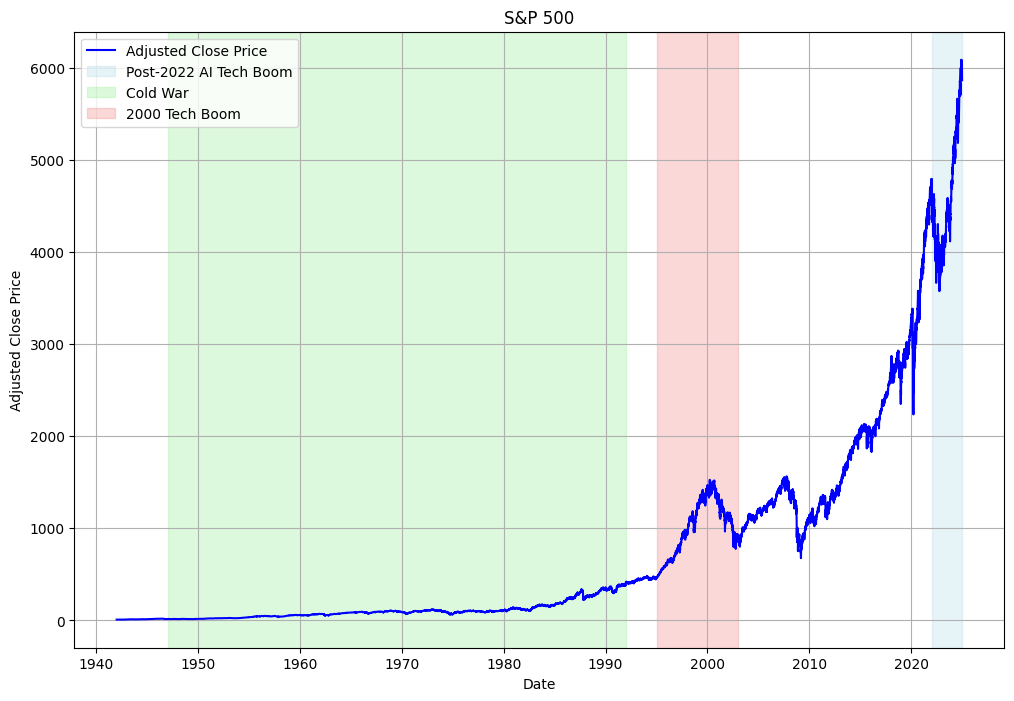

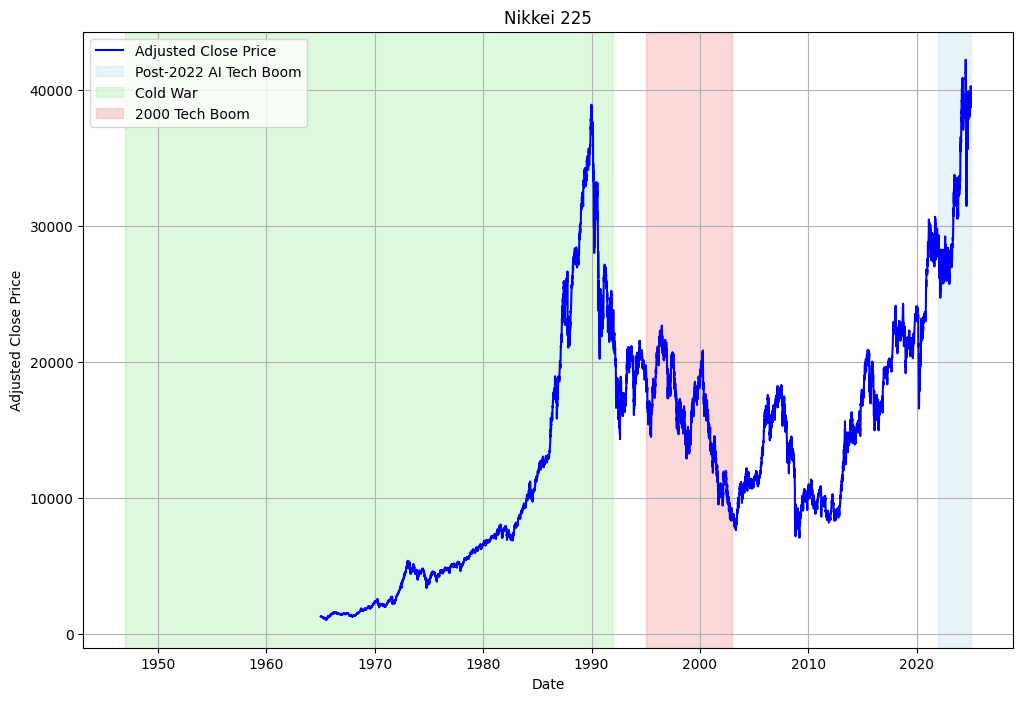

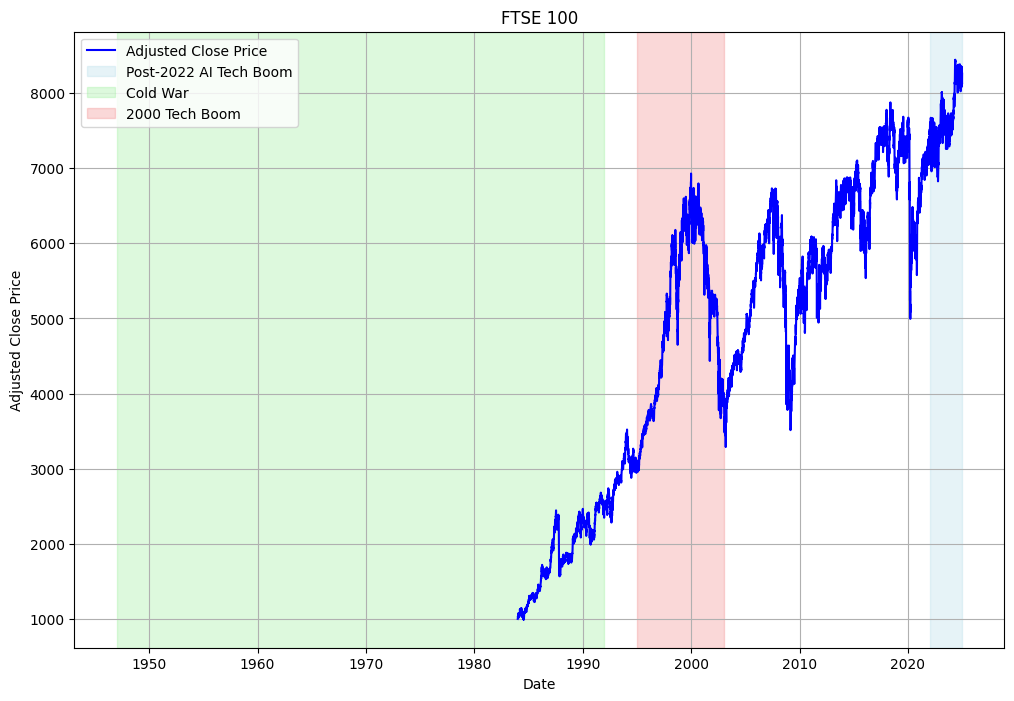

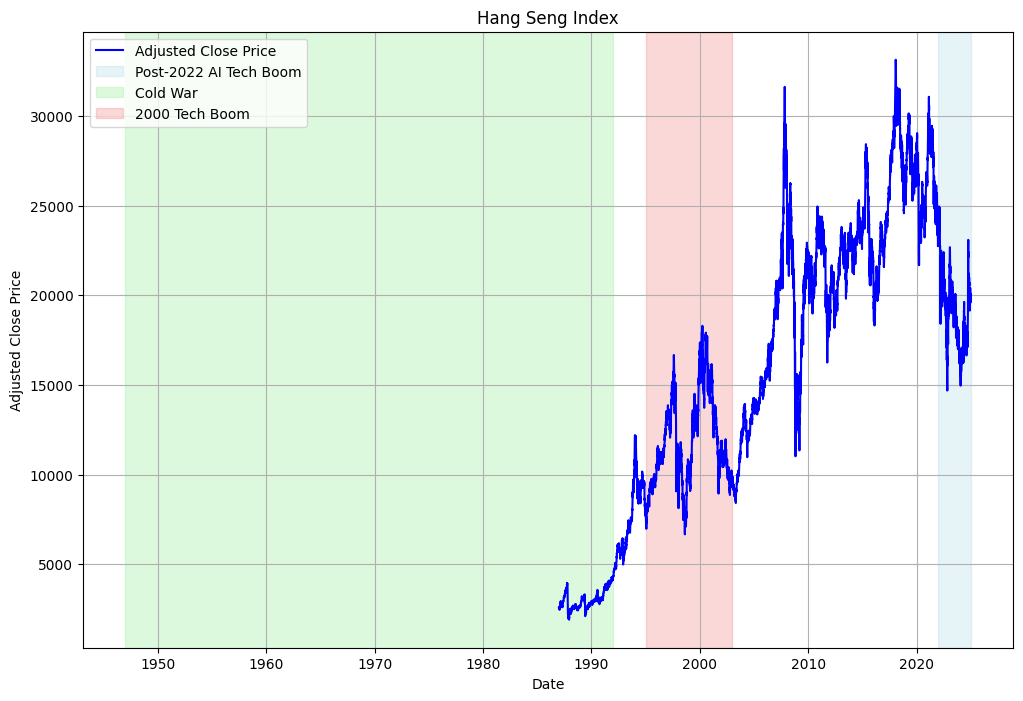

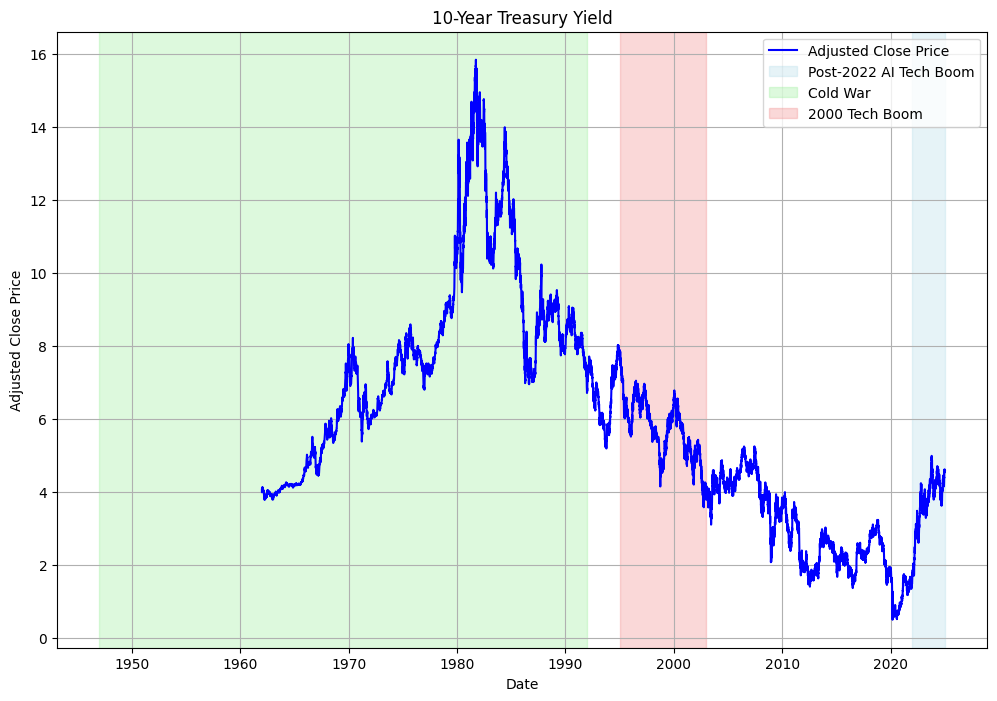

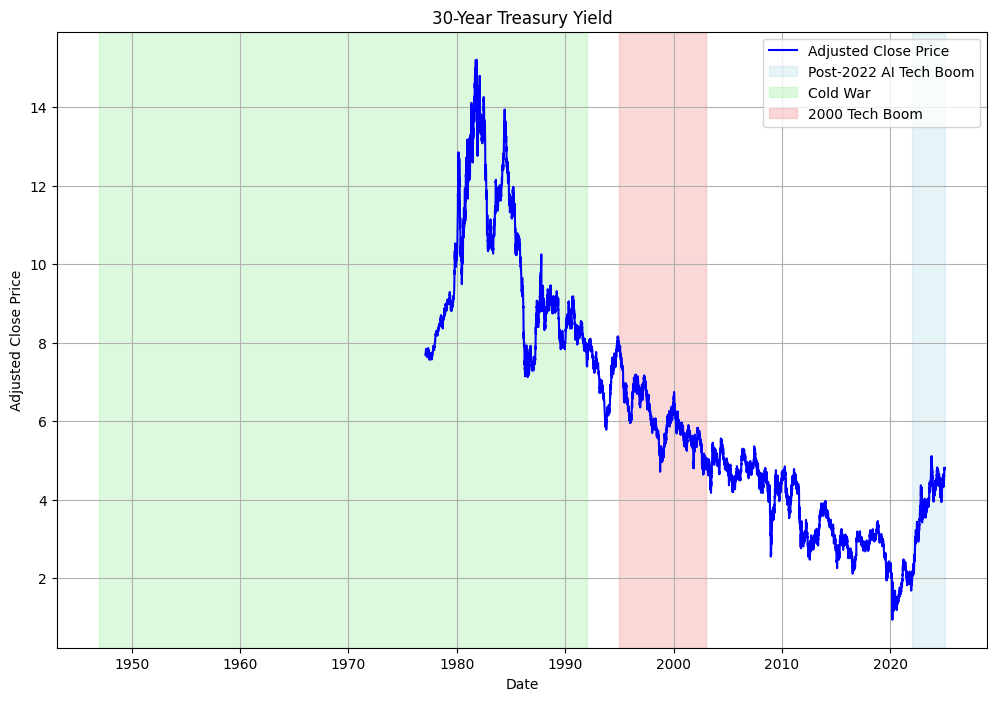

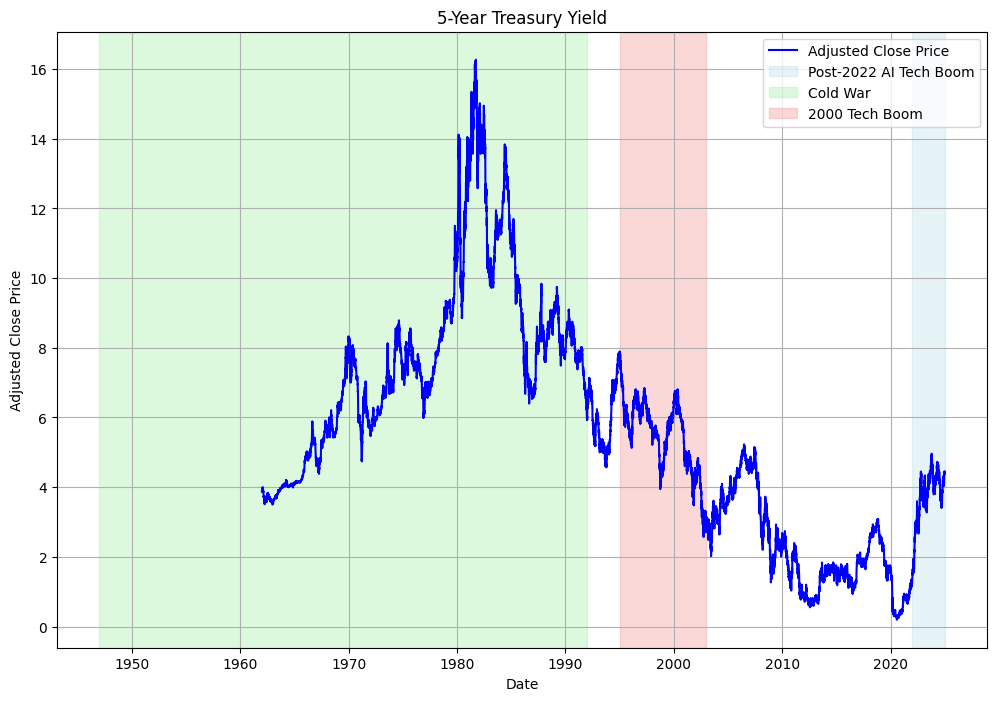

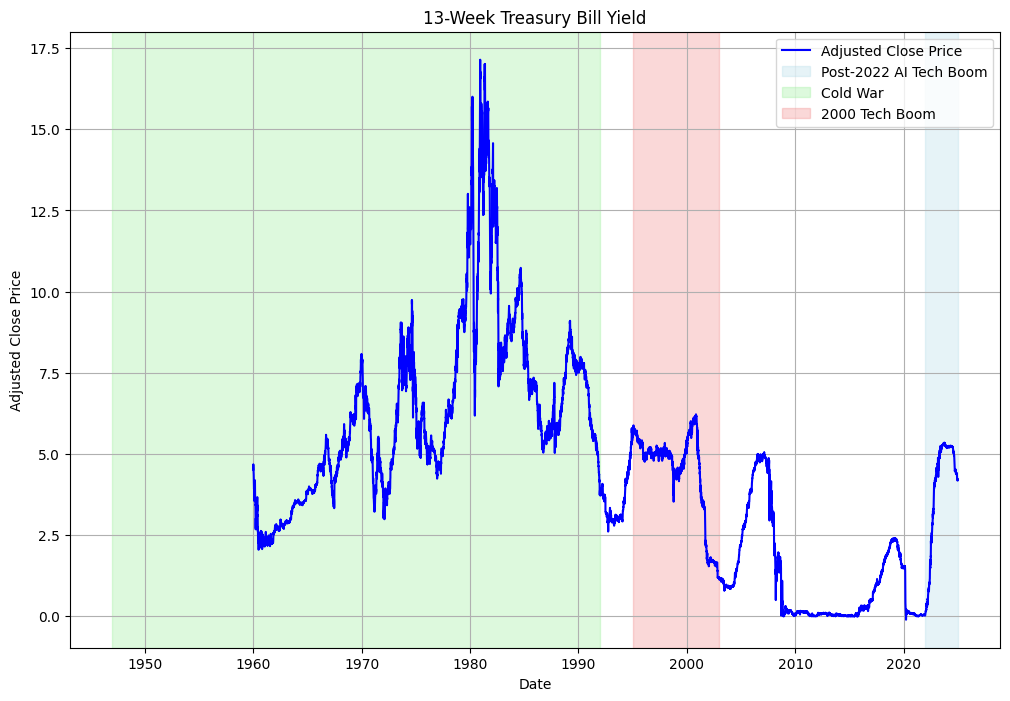

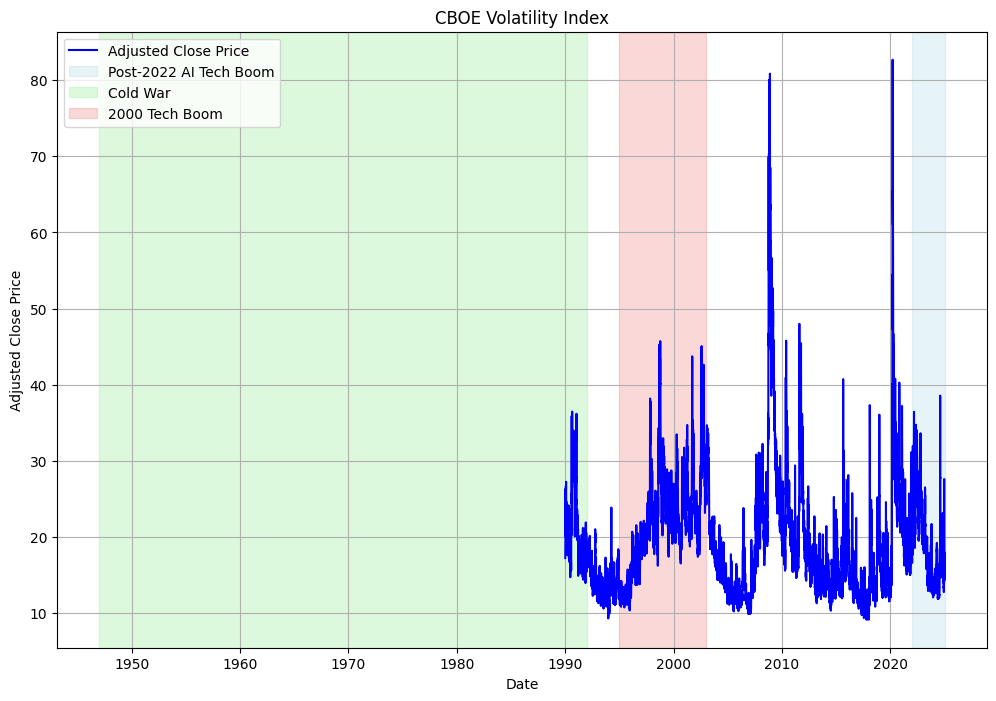

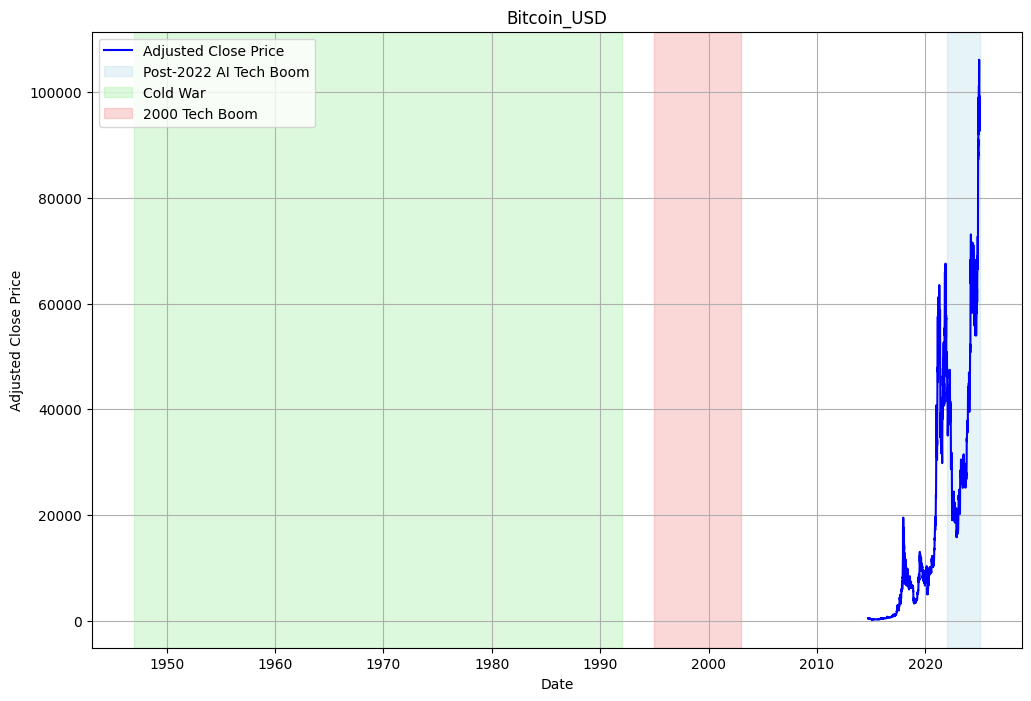

In [3]:
# PLOT YAHOO DATA
plot_ticker_with_time_period_labels(yahoo_data, time_periods, yahoo_tickers)


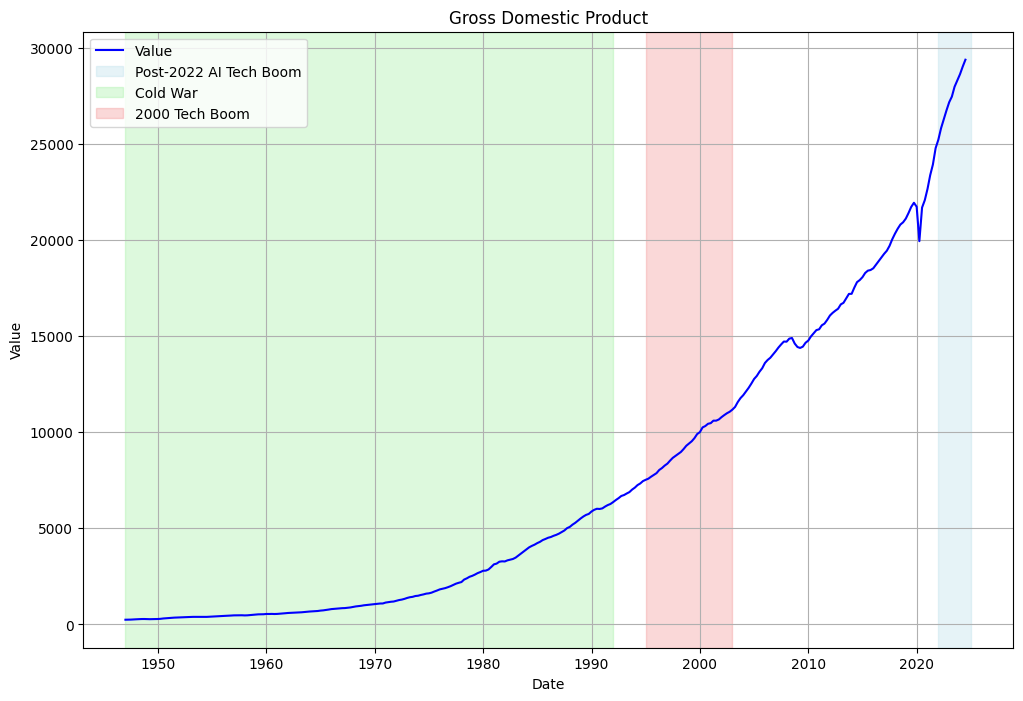

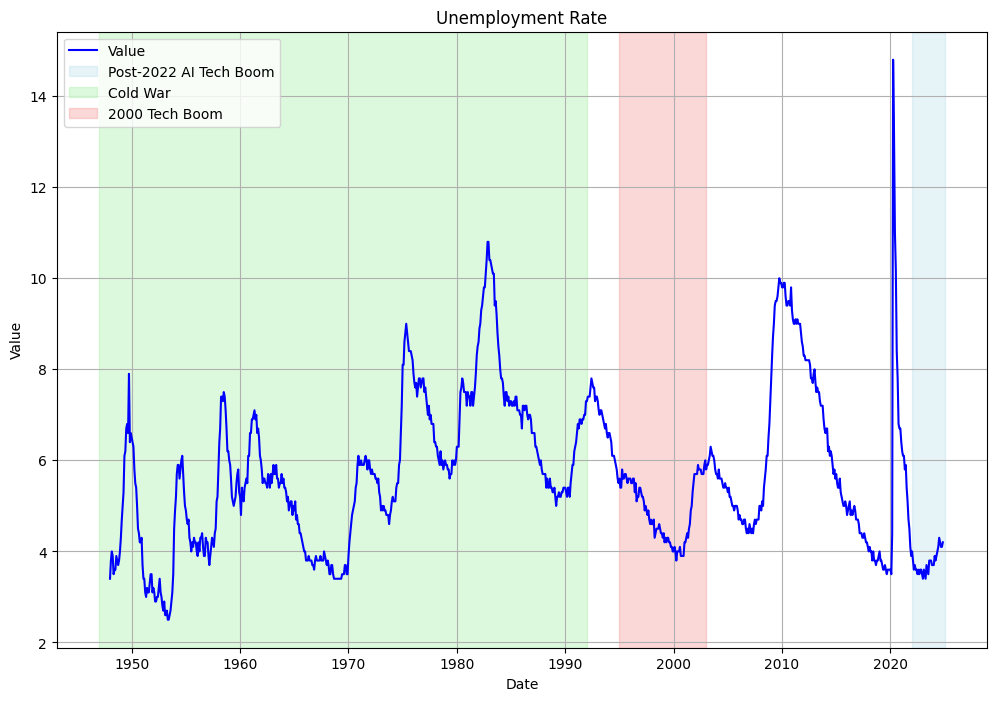

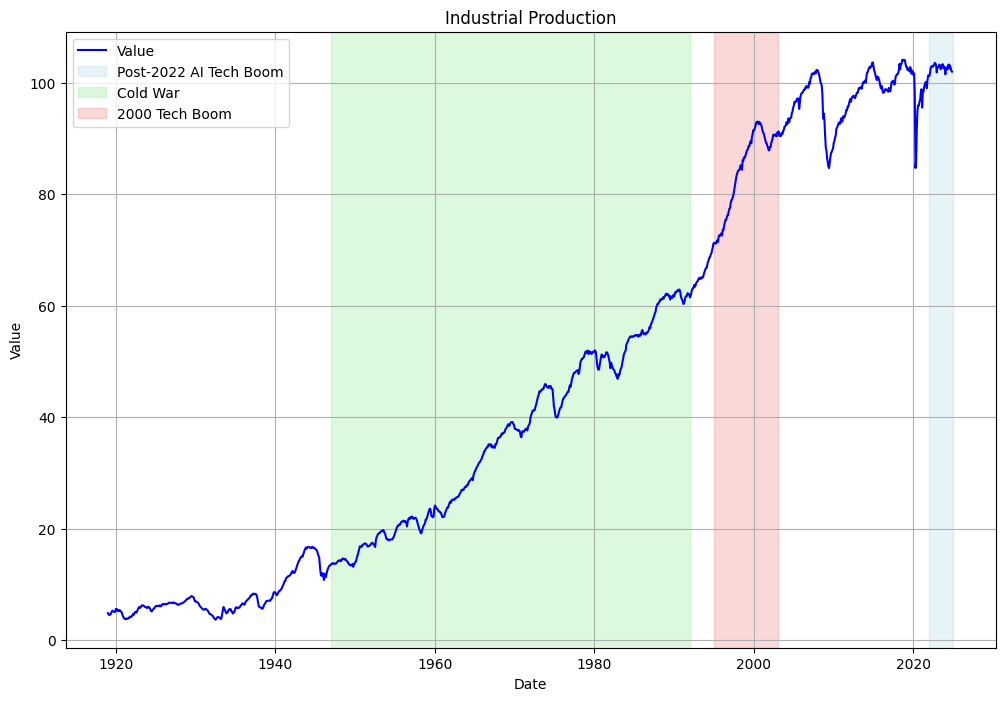

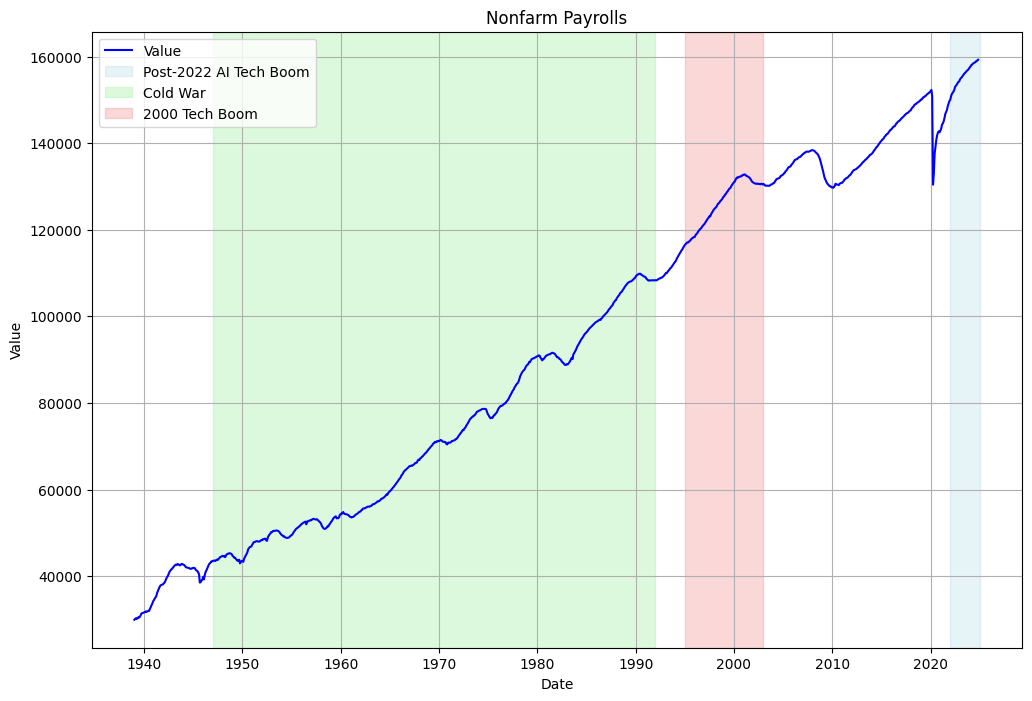

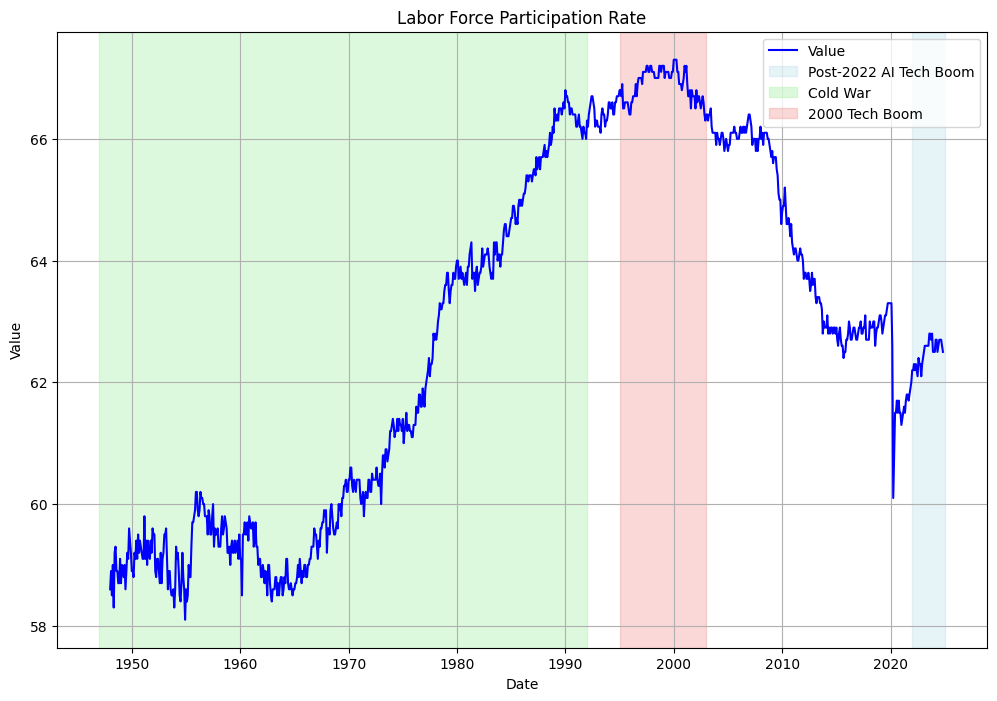

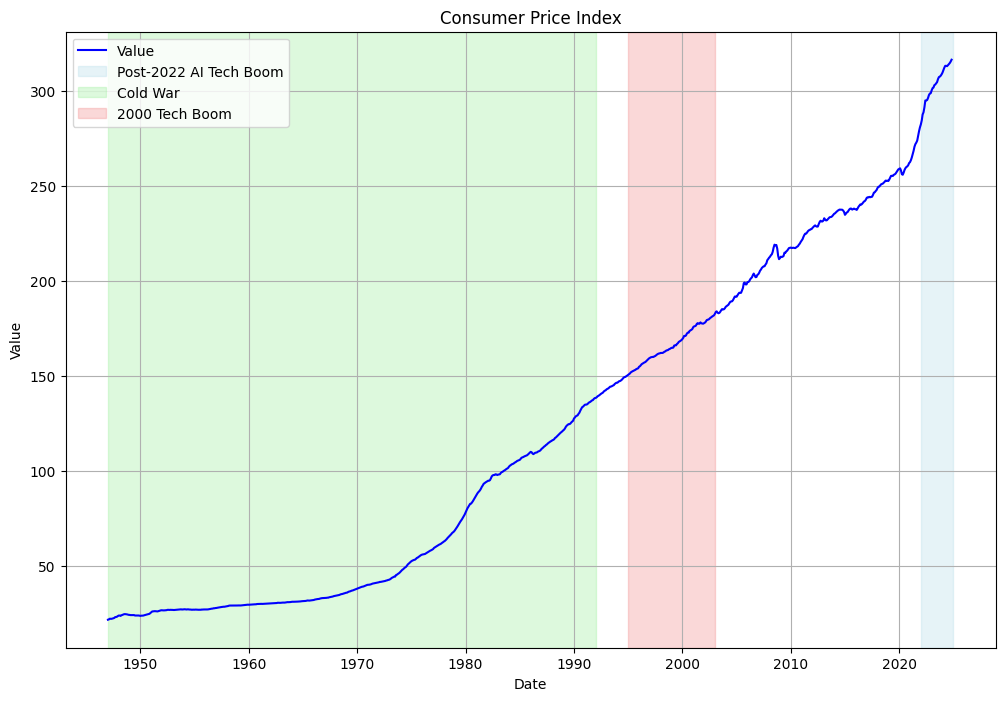

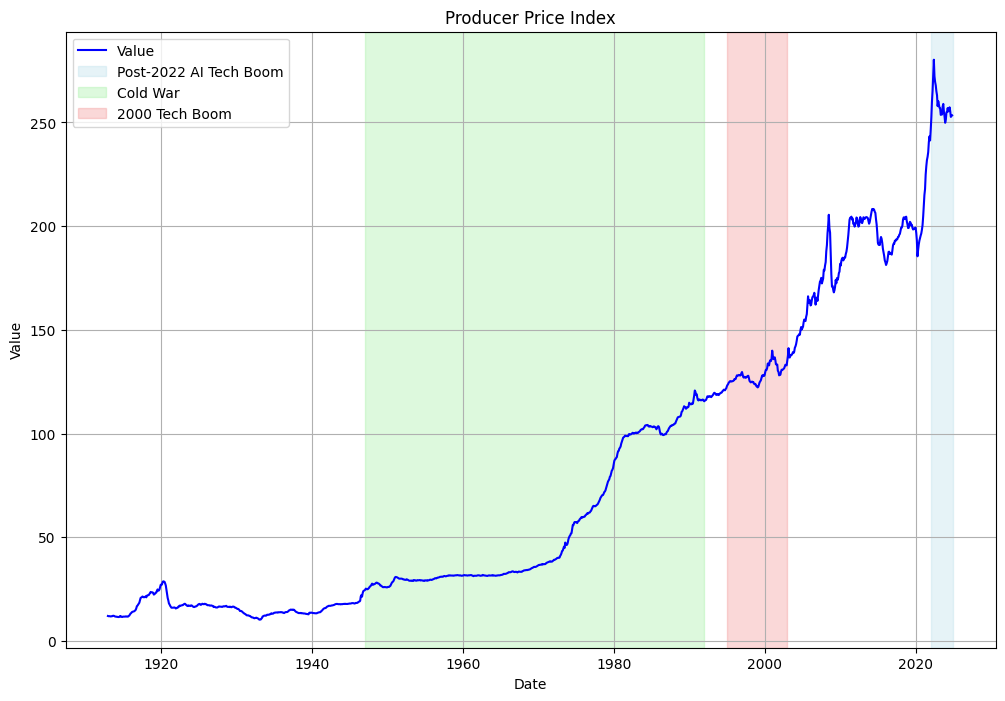

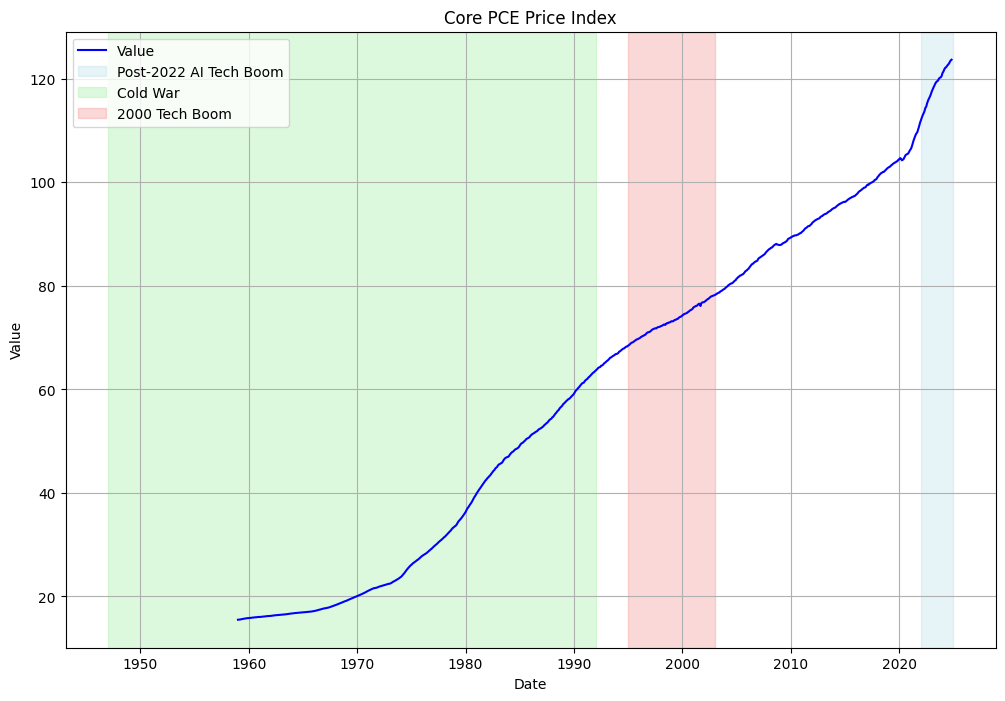

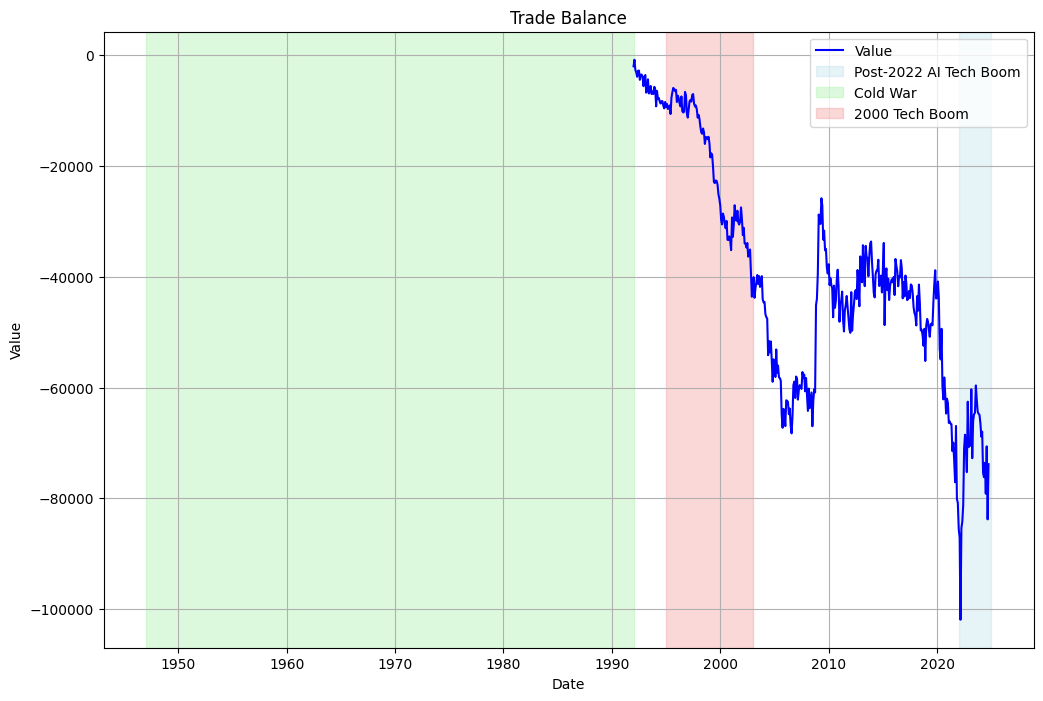

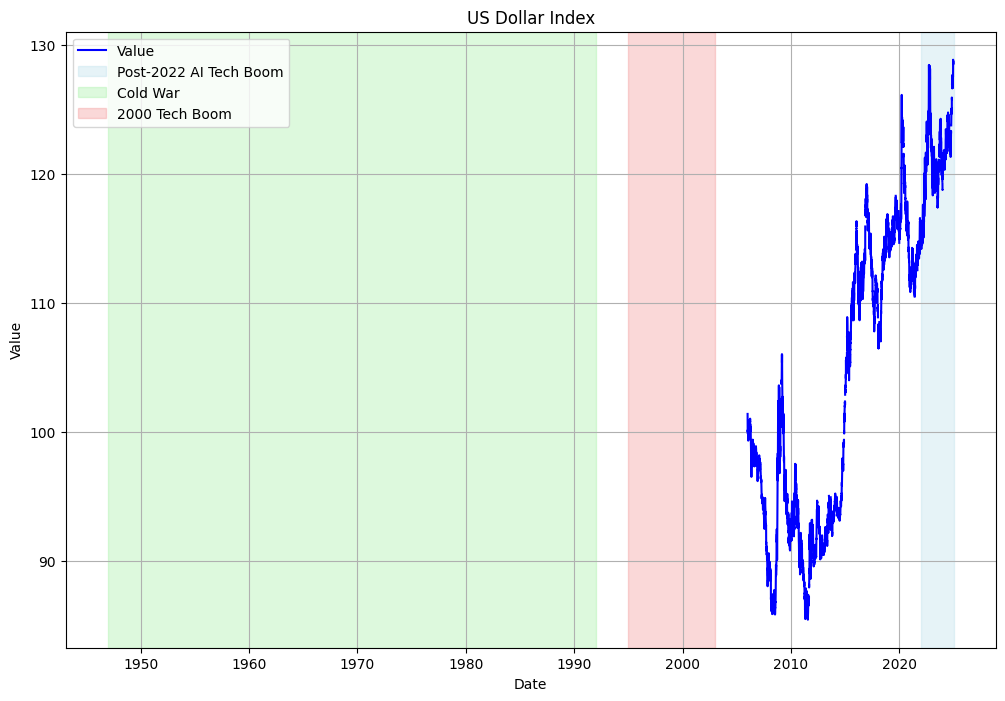

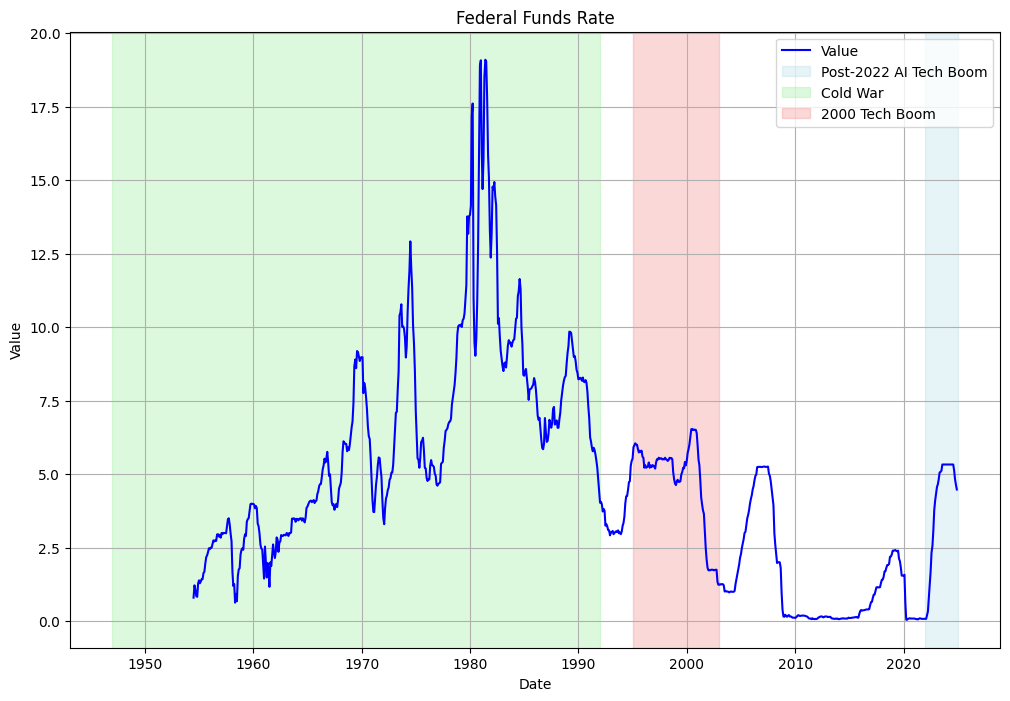

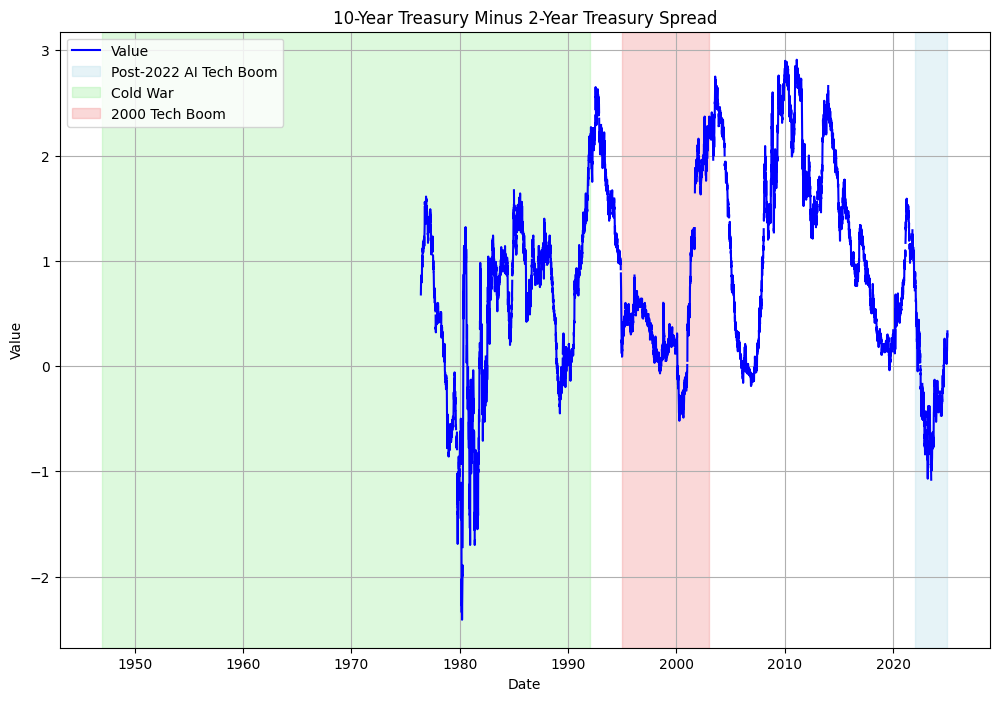

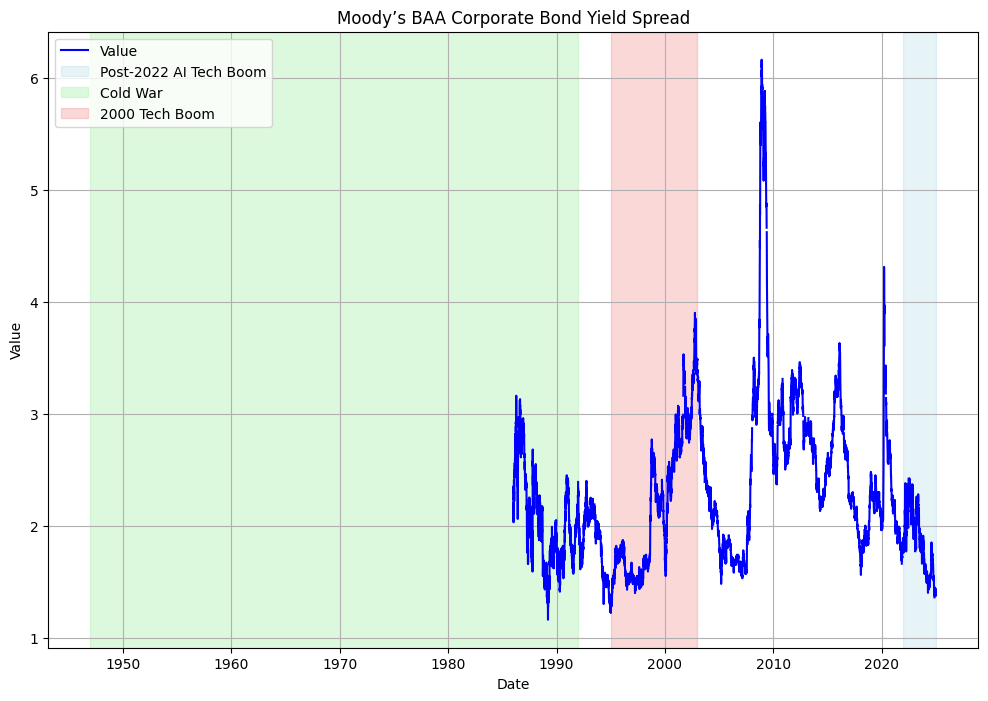

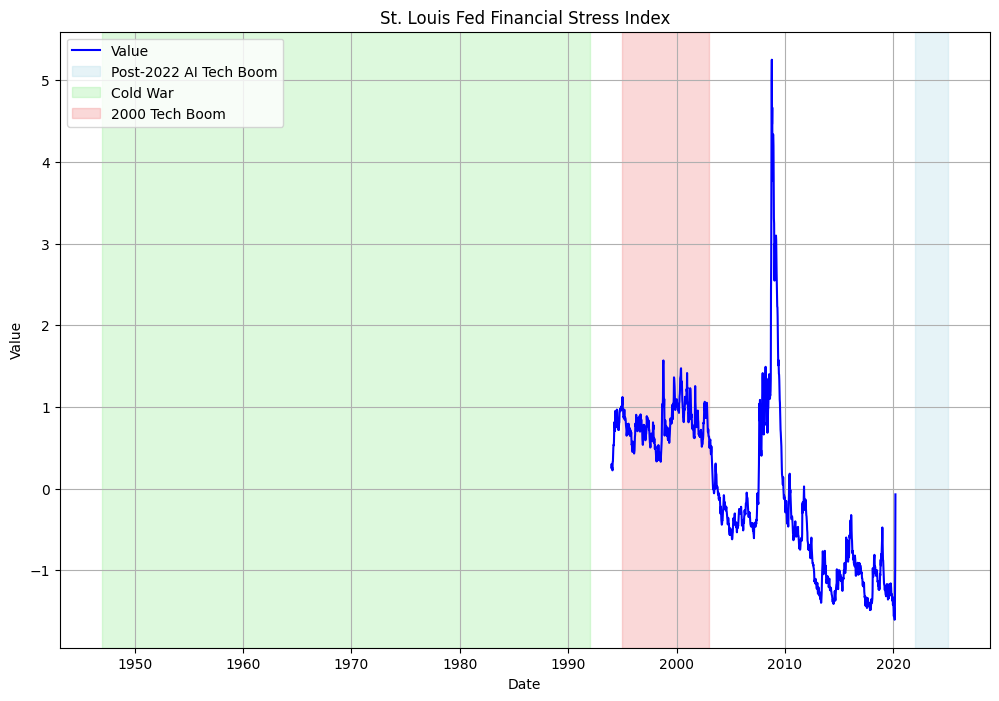

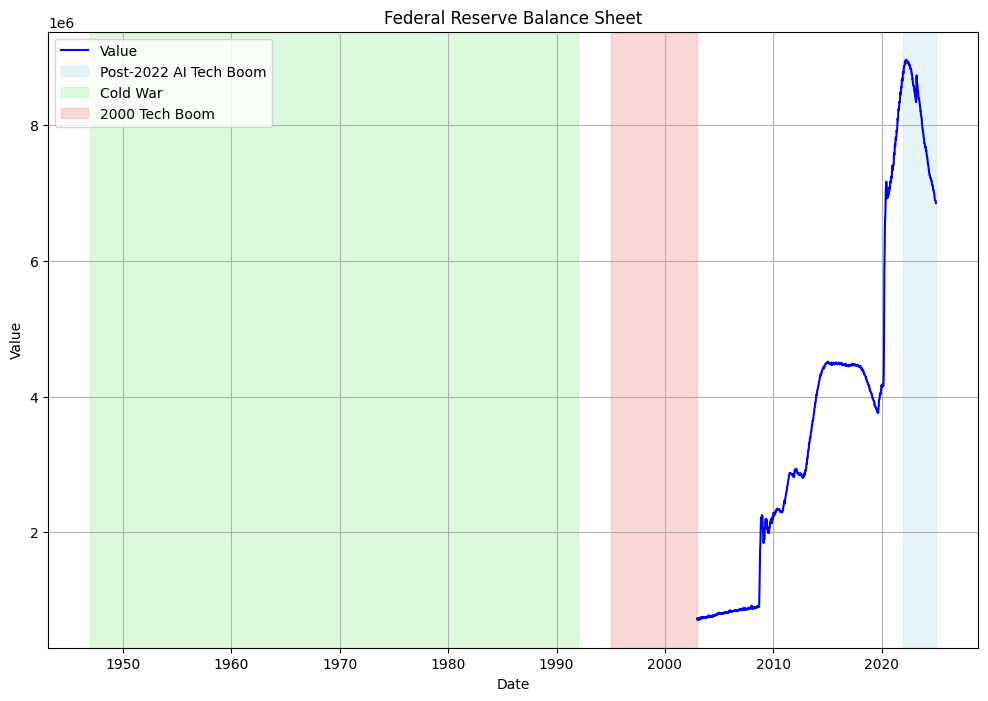

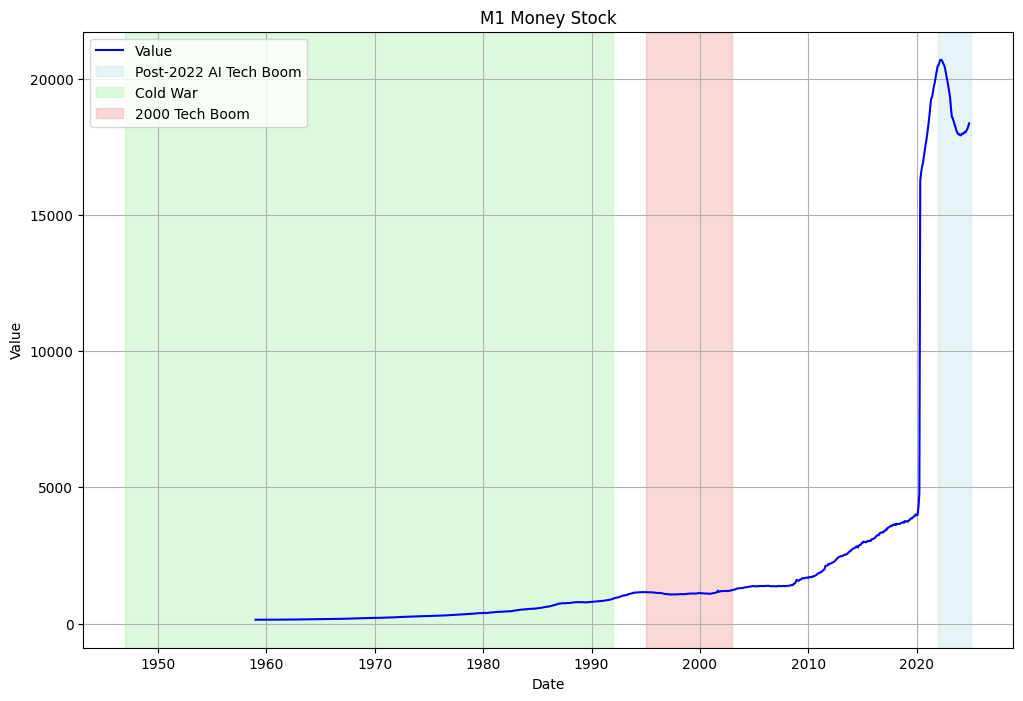

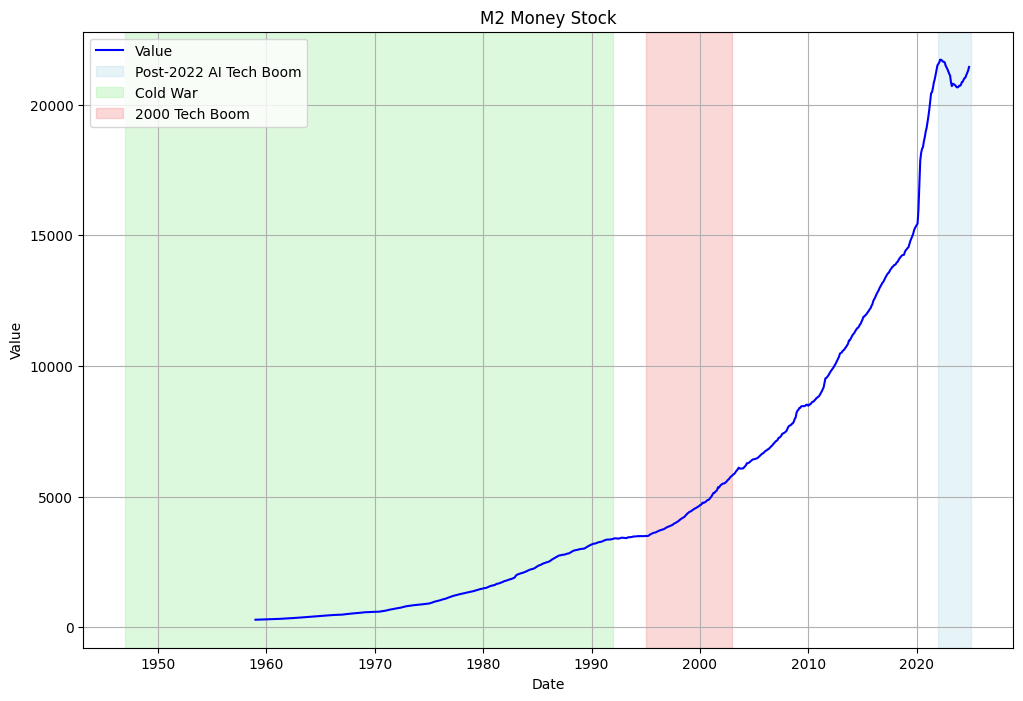

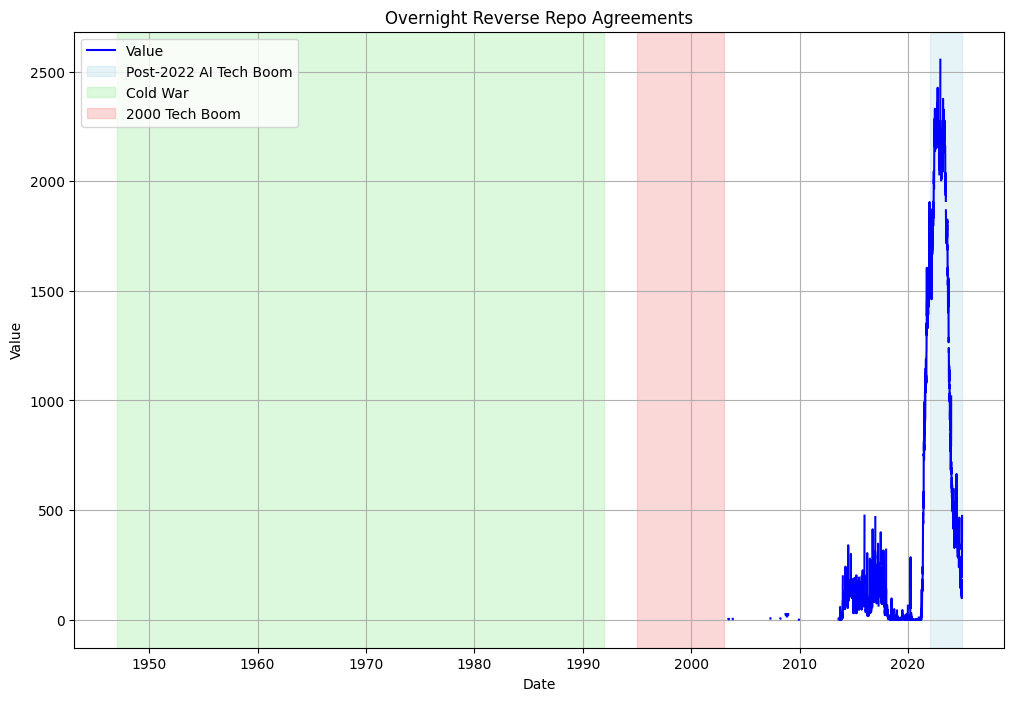

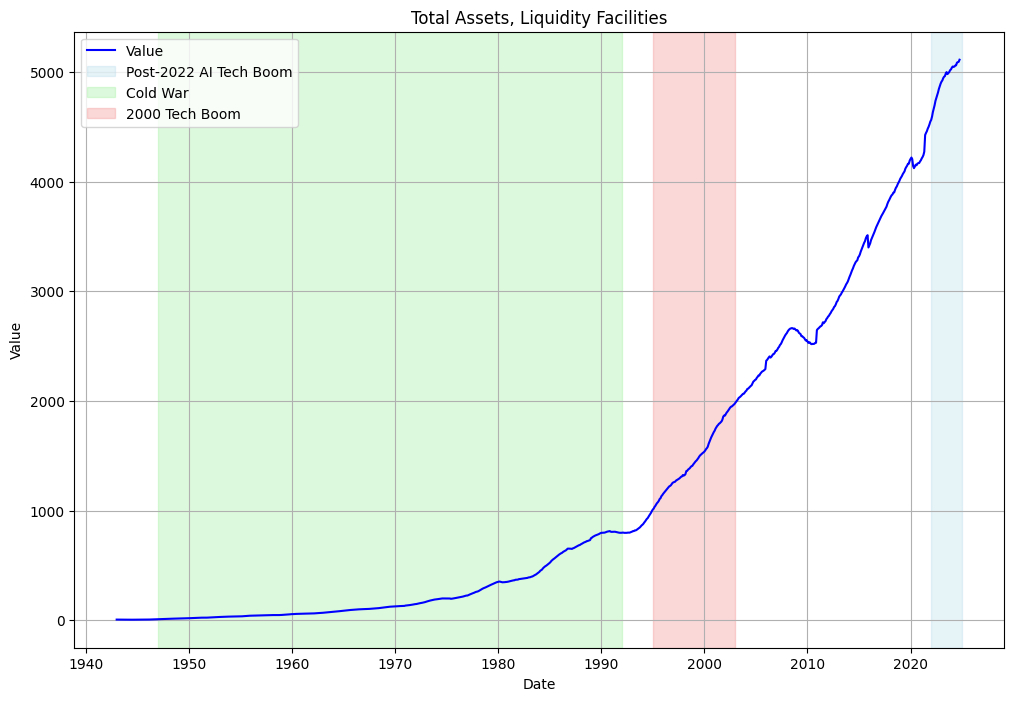

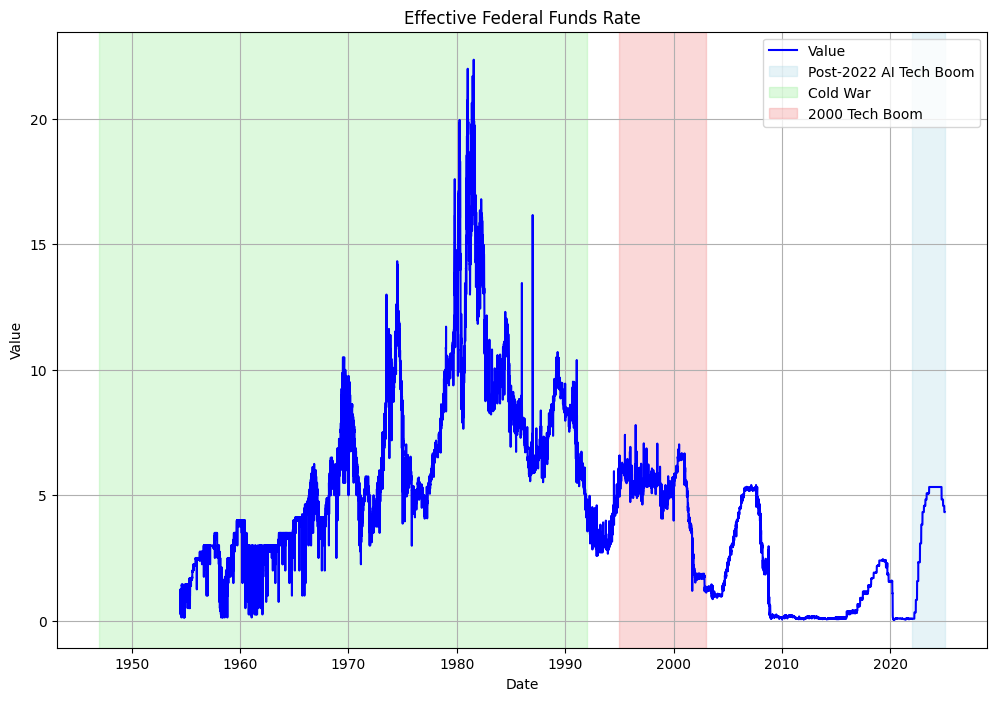

In [4]:
# PLOT FRED MACRO DATA
plot_fred_with_time_period_labels(fred_data, time_periods, fred_series)


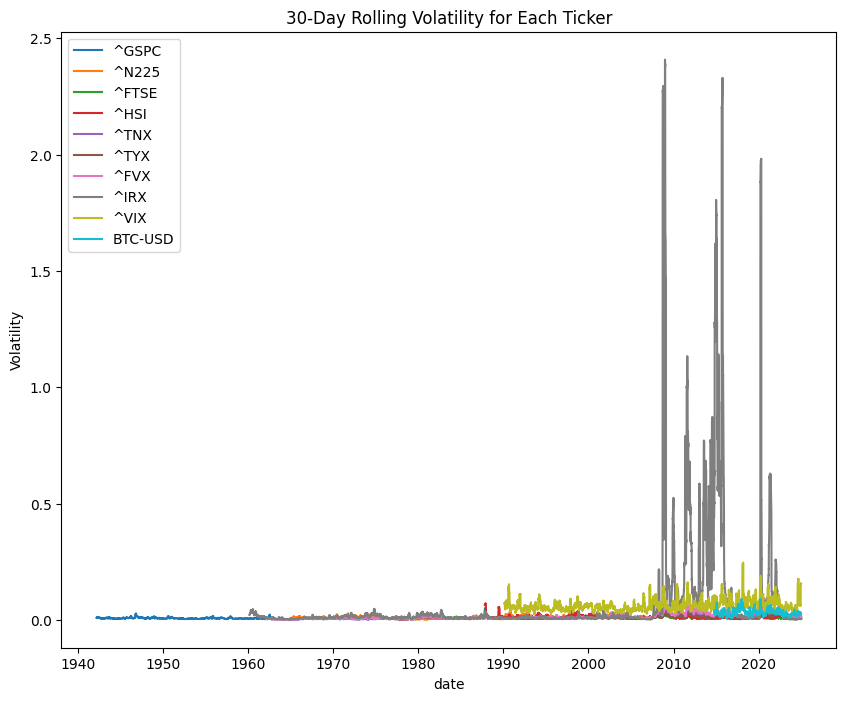

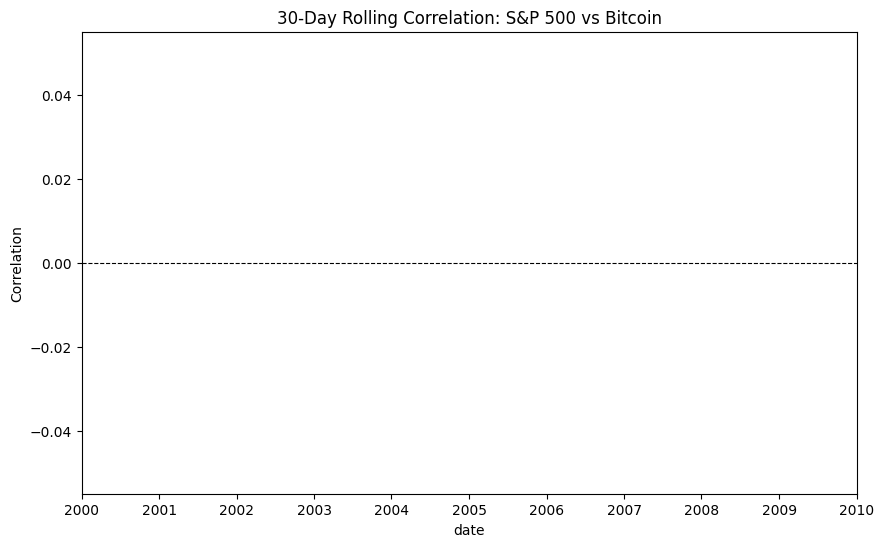

TypeError: '>=' not supported between instances of 'datetime.date' and 'str'

In [5]:
# Rolling Volatility Calculation (30-Day Window)
rolling_volatility = pd.DataFrame()

for ticker in tickers:
    ticker_data = df_yahoo[df_yahoo['symbol'] == ticker]
    rolling_volatility[ticker] = ticker_data['adjclose'].pct_change().rolling(window=30).std()

# Plot Rolling Volatility for Each Ticker
rolling_volatility.plot(figsize=(10, 8))
plt.title('30-Day Rolling Volatility for Each Ticker')
plt.ylabel('Volatility')
plt.legend(tickers)
plt.show()

# Rolling Correlations Between S&P 500 and Bitcoin
sp500_ticker = '^GSPC'  # S&P 500 Ticker
bitcoin_ticker = 'BTC-USD'  # Bitcoin Ticker

# Ensure data exists for selected tickers
if sp500_ticker in tickers and bitcoin_ticker in tickers:
    df_sp500 = df_yahoo[df_yahoo['symbol'] == sp500_ticker]
    df_bitcoin = df_yahoo[df_yahoo['symbol'] == bitcoin_ticker]
    
    # Rolling correlation (30-day window)
    rolling_corr_sp500_bitcoin = df_sp500['adjclose'].rolling(window=30).corr(df_bitcoin['adjclose'])

    # Plot Rolling Correlation
    rolling_corr_sp500_bitcoin.plot(figsize=(10, 6), title='30-Day Rolling Correlation: S&P 500 vs Bitcoin')
    plt.ylabel('Correlation')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.show()
else:
    print(f"Data for {sp500_ticker} or {bitcoin_ticker} not found.")

# Volatility Comparison Across Time Periods
volatility_by_period = {}

for period_name, (start_date, end_date) in time_periods.items():
    sp500_period = df_yahoo[(df_yahoo['symbol'] == sp500_ticker) & 
                            (df_yahoo.index >= start_date) & 
                            (df_yahoo.index <= end_date)]['adjclose'].pct_change()
    volatility_by_period[period_name] = sp500_period.std()

# Display Volatility Results
print("\nVolatility by Period:")
for period_name, volatility in volatility_by_period.items():
    print(f"{period_name}: {volatility:.4f}")

# Rolling Correlations Between Treasury Yields and Bitcoin
treasury_ticker = '^TNX'  # 10-Year Treasury Yield

if treasury_ticker in tickers and bitcoin_ticker in tickers:
    df_treasury = df_yahoo[df_yahoo['symbol'] == treasury_ticker]
    
    # Rolling correlation (30-day window)
    rolling_corr_treasury_bitcoin = df_treasury['adjclose'].rolling(window=30).corr(df_bitcoin['adjclose'])

    # Plot Rolling Correlation
    rolling_corr_treasury_bitcoin.plot(figsize=(10, 6), title='30-Day Rolling Correlation: 10-Year Treasury vs Bitcoin')
    plt.ylabel('Correlation')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.show()
else:
    print(f"Data for {treasury_ticker} or {bitcoin_ticker} not found.")

# STLFSI and VIX Comparison During Geopolitical Events
vix_ticker = '^VIX'  # CBOE Volatility Index

if vix_ticker in tickers and 'STLFSI' in df_fred['Ticker'].unique():
    df_vix = df_yahoo[df_yahoo['symbol'] == vix_ticker]
    stlfsi_data = df_fred[df_fred['Ticker'] == 'STLFSI']

    # Merge data on dates
    df_stress_vol = pd.merge(df_vix['adjclose'], stlfsi_data['Value'], left_index=True, right_index=True, how='inner')
    df_stress_vol.columns = ['VIX', 'STLFSI']

    # Plot Comparison
    df_stress_vol.plot(figsize=(10, 8), secondary_y='STLFSI', title='VIX and STLFSI During Geopolitical Events')
    plt.ylabel('VIX')
    plt.show()
else:
    print("Data for VIX or STLFSI not found.")
